# Using `ez_zarr` to explore Fractal outputs

Silvia Barbiero, Michael Stadler

# Disclaimer

The `hcs_wrappers` module described here is only provided for legacy
reasons and not being further developed. For new projects, we recommend
to use the `ome_zarr` module instead (see [getting started with
individual
images](https://fmicompbio.github.io/ez_zarr/getting_started_Image/)).

# Goal

The aim of `ez_zarr` is to provide easy, high-level access to high
content screening microscopy data, stored as OME-Zarr filesets according
to the [NGFF](https://ngff.openmicroscopy.org/latest/) specifications
with additional metadata fields, for example the ones generated by the
[Fractal](https://fractal-analytics-platform.github.io/) platform.

The goal is that users can write simple scripts working with plates,
wells and fields of view, without having to understand how these are
represented within an OME-Zarr fileset.

# Installation

`ez_zarr` is hosted on GitHub at
[github.com/fmicompbio/ez_zarr](https://github.com/fmicompbio/ez_zarr)
and the documentation can be found at
[fmicompbio.github.io/ez_zarr](https://fmicompbio.github.io/ez_zarr/).

The release version of `ez_zarr` can be installed using:

``` bash
pip install ez-zarr
```

The current (development) version of `ez_zarr` can be installed from
github.com using:

``` bash
pip install git+ssh://git@github.com/fmicompbio/ez_zarr.git
```

# Quickstart

Note: If you prefer to run these examples interactively, you can also
download them as an [ipynb
notebook](https://fmicompbio.github.io/ez_zarr/getting_started_hcs_wrappers.ipynb).

Here are some examples of how you can use `ez_zarr`:

## Download example data

To run the code below, you will first need to download some Fractal
output data. You can do this for example by running the following from a
terminal:

``` bash
# Download small Fractal output from Zenodo
curl -o temp.zip https://zenodo.org/records/10519143/files/20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr.zip

# Unzip and remove the temporary zip file
unzip temp.zip
rm temp.zip
```

or directly from within a python notebook or session using:

In [1]:
import requests
import zipfile
import os

# for info on data see: https://zenodo.org/records/10257149
url = 'https://zenodo.org/records/10519143/files/20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr.zip'

# download
response = requests.get(url)
with open('temp.zip', 'wb') as temp_zip:
    temp_zip.write(response.content)

# unzip to current directory
with zipfile.ZipFile('temp.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# clean up
os.remove('temp.zip')

## Load packages

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from skimage import color

from ez_zarr import hcs_wrappers, plotting

## Open OME-Zarr file set

We open a single OME-Zarr directory, typically representing a single
plate:

In [3]:
zarr_directory = '20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr'
plate = hcs_wrappers.FractalZarr(zarr_directory, name = 'cardio-d14')
plate

FractalZarr cardio-d14
  path: 20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr
  n_wells: 1
  n_channels: 1 (DAPI)
  n_pyramid_levels: 5
  pyramid_zyx_scalefactor: {'0': array([1., 2., 2.])}
  full_resolution_zyx_spacing (µm): [1.0, 0.1625, 0.1625]
  segmentations: nuclei, empty
  tables (measurements): FOV_ROI_table, well_ROI_table, nuclei_ROI_table, nuclei, expected_table_well_ROI_table_False_0_0, expected_table_well_ROI_table_True_0_0, expected_table_FOV_ROI_table_False_0_0, expected_table_FOV_ROI_table_True_0_0, expected_table_well_ROI_table_0_True_0_0, expected_table_masked_nuclei_ROI_table_0_True_0_0, expected_table_masked_nuclei_ROI_table_1_True_0_0

`plate` represents a maximum intensity projection of an acquisition with
1 well and 1 channel.

There are 5 `pyramid_levels` available (0 to 4), meaning that in
addition to the full resolution data (level 0), we have four more levels
that provide the data in 2-fold lower resolutions (see
`pyramid_zyx_scalefactor`), for example for faster plotting.

This OME-Zarr fileset also contains a segmentation (`nuclei`), for which
measurements have been extracted and saved in the table `nuclei`. In
addition, there are some further tables, such as `FOV_ROI_table`, which
contains the coordinates of the fields of view, or `nuclei_ROI_table`,
which contains the bounding box coordinates for the segmented nuclei.

## Get information from `plate`

You can obtain information on the content available in the fileset:

In [4]:
# path to the OME-Zarr fileset
plate.get_path()

'20200812-CardiomyocyteDifferentiation14-Cycle1_mip.zarr'

In [5]:
# available channels
plate.get_channels()

[{'color': '00FFFF',
  'label': 'DAPI',
  'wavelength_id': 'A01_C01',
  'window': {'end': 800, 'max': 65535, 'min': 0, 'start': 110}}]

In [6]:
# available wells
plate.get_wells()
plate.get_wells(simplify=True)

['B03']

In [7]:
# available labels
plate.get_label_names()

['nuclei', 'empty']

In [8]:
# available tables
plate.get_table_names()

['FOV_ROI_table',
 'well_ROI_table',
 'nuclei_ROI_table',
 'nuclei',
 'expected_table_well_ROI_table_False_0_0',
 'expected_table_well_ROI_table_True_0_0',
 'expected_table_FOV_ROI_table_False_0_0',
 'expected_table_FOV_ROI_table_True_0_0',
 'expected_table_well_ROI_table_0_True_0_0',
 'expected_table_masked_nuclei_ROI_table_0_True_0_0',
 'expected_table_masked_nuclei_ROI_table_1_True_0_0']

In [9]:
# zyx pixel spacing in micrometers for pyramid levels
# ... for images
plate.level_zyx_spacing_images

{'0': [[1.0, 0.1625, 0.1625],
  [1.0, 0.325, 0.325],
  [1.0, 0.65, 0.65],
  [1.0, 1.3, 1.3],
  [1.0, 2.6, 2.6]]}

In [10]:
# ... for labels
plate.level_zyx_spacing_labels

{'nuclei': [[1.0, 0.65, 0.65],
  [1.0, 1.3, 1.3],
  [1.0, 2.6, 2.6],
  [1.0, 5.2, 5.2],
  [1.0, 10.4, 10.4]],
 'empty': [[1.0, 0.65, 0.65],
  [1.0, 1.3, 1.3],
  [1.0, 2.6, 2.6],
  [1.0, 5.2, 5.2],
  [1.0, 10.4, 10.4]]}

## Extract a table from the OME-Zarr fileset

The tables are stored within the fileset as described in the [Fractal
documentation](https://fractal-analytics-platform.github.io/fractal-tasks-core/tables/).

As mentioned the goal of `ez_zarr` is to abstract the internal structure
and make it simple to obtain these tables, if necessary accumulated over
many wells, as a `pandas.DataFrame` :

In [11]:
df = plate.get_table(table_name='FOV_ROI_table')
df

| FieldIndex | well | x_micrometer | y_micrometer | z_micrometer | len_x_micrometer | len_y_micrometer | len_z_micrometer | x_micrometer_original | y_micrometer_original |
|:-----|:---|------:|------:|------:|-------:|-------:|-------:|---------:|---------:|
| FOV_1 | B03 | 0 | 0 | 0 | 416 | 351 | 1 | -1448.3 | -1517.7 |
| FOV_2 | B03 | 416 | 0 | 0 | 416 | 351 | 1 | -1032.3 | -1517.7 |

or `anndata.AnnData` object:

In [13]:
ann = plate.get_table(table_name='FOV_ROI_table', as_AnnData=True)
ann

AnnData object with n_obs × n_vars = 2 × 8
    obs: 'well'

## Get an overview of a full well

`get_image_ROI()` extracts a rectangular region of interest (ROI) from a
well image by coordinates. If no coordinates or other arguments are
given, it returns the whole well at the lowest available resolution:

In [14]:
my_well = plate.get_wells(simplify=True)[0]
print(my_well)

img = plate.get_image_ROI()
print(img.shape) # (ch, z, y, x)

B03
(1, 1, 135, 320)

Such an image array can be easily plotted using
`matplotlib.pyplot.imshow`:

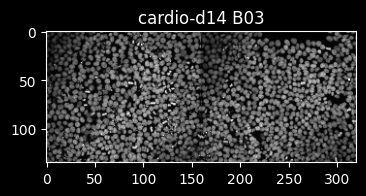

In [15]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(4, 4))
    fig.set_dpi(100)

    plt.imshow(img[0,0], cmap='gray', vmin=100, vmax=600)
    plt.title(plate.name + ' ' + my_well)
    plt.show()
    plt.close()

With `plot_well()`, `ez_zarr` provides a convenient function for this
use case that automatically extracts the well image and plots it.
Because it has access to the image metadata, it can also add for example
a scale bar:

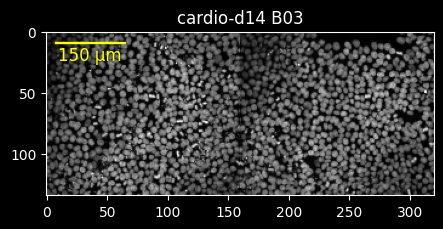

In [16]:
plate.plot_well(well=my_well,
                channels=[0],
                channel_colors=['white'],
                channel_ranges=[[100, 600]],
                title=plate.name + ' ' + my_well,
                scalebar_micrometer=150,
                scalebar_color='yellow',
                scalebar_position='topleft',
                scalebar_label=True,
                fig_width_inch=5,
                fig_height_inch=4,
                fig_dpi=100)

`plot_well()` and also `plot_plate()` use internally
`ez_zarr.plotting.plot_image()` which is a convenient wrapper around
`matplotlib.pyplot.imshow`. `plot_image()` can also be used directly if
you want to work with image arrays (for examples, see section “Working
with segmentation masks” below).

## Get salient regions at higher resolution

`get_image_grid_ROIs()` allows you to split the well image into a
rectangular grid of `num_x`-by-`num_y` regions, and automatically select
the `num_select` top regions based on a given property
(`sample_method`).

Here, we pick three regions with the highest signal in channel zero
(DAPI):

[(216, 432, 768, 1024), (432, 648, 2048, 2304), (432, 648, 768, 1024)]
3

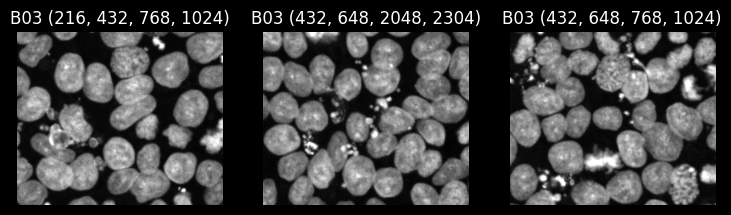

In [17]:
coord_list, img_list = plate.get_image_grid_ROIs(well = my_well,
                                                 pyramid_level=1,
                                                 num_x=10, num_y=5, num_select=3,
                                                 sample_method='sum',
                                                 channel=0)
print(coord_list) # list of (y_start, y_end, x_start, x_end)
print(len(img_list))

with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(9,3))
    fig.set_dpi(100)
    for i in range(len(img_list)):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img_list[i][0,0], cmap='gray', vmin=100, vmax=600)
        plt.axis('off')
        plt.title(my_well + ' ' + str(coord_list[i]))
    plt.show()
    plt.close()

## Zoom in

Alternatively, we can zoom in by coordinates:

(1, 1, 71, 51)

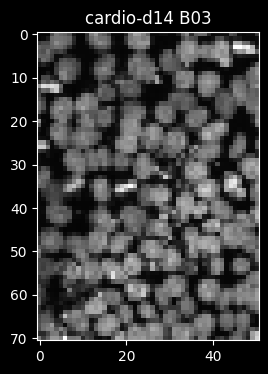

In [18]:
img = plate.get_image_ROI(well=my_well,
                          upper_left_yx=(50, 40),
                          lower_right_yx=(120, 90))
print(img.shape)

with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(4, 4))
    fig.set_dpi(100)

    plt.imshow(img[0,0], cmap='gray', vmin=100, vmax=600)
    plt.title(plate.name + ' B03')
    plt.show()
    plt.close()

So far, we have been automatically using the lowest resolution (highest)
pyramid level version of the data, and the pixel coordinates above refer
to that space.

If we want to get the same image region at a higher resolution (for
example `pyramid_level=1`), we need to adjust these coordinates. For
this, we have two options:

-   Convert the coordinates manually using the
    `convert_pixel_to_pixel()` function. We then use these new
    coordinates with `get_image_ROI()` to extract the same region from
    the higher resolution pyramid level:

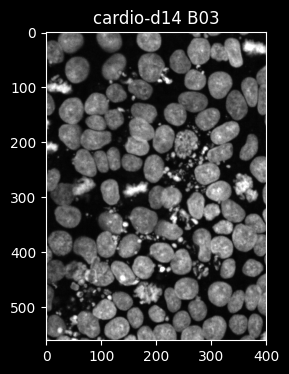

In [19]:
# convert coordinates manually from lowest-resolution (None, here: 4)
#   to a higher resolution (1) pyramid level
# remark: coordinates are (z,y,x)
new_upper_left = plate.convert_pixel_to_pixel(zyx = (0, 50, 40),
                                              pyramid_level_from = None,
                                              pyramid_level_to=1)
new_lower_right = plate.convert_pixel_to_pixel(zyx = (0, 120, 90),
                                               pyramid_level_from = None,
                                               pyramid_level_to=1)

# extract image
img = plate.get_image_ROI(well=my_well,
                          upper_left_yx=new_upper_left[1:],
                          lower_right_yx=new_lower_right[1:],
                          pyramid_level=1)

with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(4, 4))
    fig.set_dpi(100)

    plt.imshow(img[0,0], cmap='gray', vmin=100, vmax=600)
    plt.title(plate.name + ' ' + my_well)
    plt.show()
    plt.close()

-   Convert the coordinates automatically inside `plot_well()`. The
    function `plot_well()` is flexible and can also plot just a
    sub-region of a well, defined by coordinates. The parameter
    `pyramid_level_coord` can be used to define the reference pyramid
    level that these coordinates refer to. This can be a different
    pyramid level than the one from which the image is extracted
    (defined by `pyramid_level`):

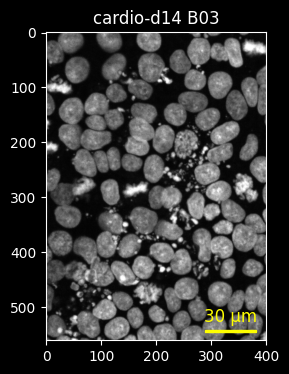

In [20]:
plate.plot_well(well=my_well,
                pyramid_level=1,       # extract image from this level
                pyramid_level_coord=4, # coordinates refer to this level
                upper_left_yx=(50,40),
                lower_right_yx=(120,90),
                channels=[0],
                channel_colors=['white'],
                channel_ranges=[[100, 600]],
                title=plate.name + ' ' + my_well,
                scalebar_micrometer=30,
                scalebar_color='yellow',
                scalebar_position='bottomright',
                scalebar_label=True,
                fig_width_inch=4,
                fig_height_inch=4,
                fig_dpi=100)

## Coordinate conversions

As mentioned the pixel coordinates depend on the `pyramid_level`. The
image metadata makes it easy to convert between pixel coordinates and
micrometer coordinates, or pixel coordinates referring to different
pyramid levels:

In [21]:
zyx = (1, 230, 180) # highest pyramid level (4)
print('starting coordinates (pyramid_level=4): ' + str(zyx))

# convert from pixel to micrometers
zyx_um = plate.convert_pixel_to_micrometer(zyx, pyramid_level=4)
print('in micrometer: ' + str(zyx_um))

# convert from micrometers to pixels
zyx_px = plate.convert_micrometer_to_pixel(zyx_um, pyramid_level=4)
print('back in pixel: ' + str(zyx_px))

# convert pixels between pyramid levels
zyx_px_0 = plate.convert_pixel_to_pixel(zyx_px, pyramid_level_from=4, pyramid_level_to=0)
print('in pixel (pyramid_level=0): ' + str(zyx_px_0))

starting coordinates (pyramid_level=4): (1, 230, 180)
in micrometer: (1.0, 598.0, 468.0)
back in pixel: (1, 230, 180)
in pixel (pyramid_level=0): (1, 3680, 2880)

These functions are also used by `plot_well()` internally to add a scale
bar to the image plot, as we have seen above.

## Working with segmentation masks

When segmentation masks (labels) are available, we can also extract
them. For example, we can plot the labels with transparency on top of
the image:

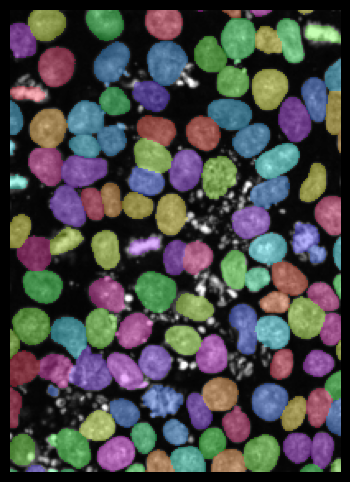

In [22]:
# select which object to plot
label = 'nuclei'
img_pl = 2  # image pyramid level

# find corresponding mask pyramid level
img_name = plate.image_names[0]
pl_match = [plate.level_zyx_spacing_images[img_name][img_pl] == x for x in plate.level_zyx_spacing_labels[label]]
assert sum(pl_match) == 1
msk_pl = pl_match.index(True)

# load image and corresponding mask
img = plate.get_image_ROI(well=my_well, pyramid_level=img_pl,
                          upper_left_yx=(200, 160), lower_right_yx=(480, 360))
msk = plate.get_label_ROI(label_name=label, well=my_well, pyramid_level=msk_pl,
                          upper_left_yx=(200, 160), lower_right_yx=(480, 360))
assert img[0].shape == msk.shape

# plot image and mask
plotting.plot_image(im=img, msk=msk, msk_alpha=0.3,
                    channels=[0], channel_colors=['white'], channel_ranges=[[100,600]],
                    fig_width_inch=6, fig_height_inch=6, fig_dpi=100)

Using the tables, we can get the bounding box coordinates in micrometers
from `nuclei_ROI_table` (here just showing the rows 100 to 110):

In [23]:
nucl = plate.get_table('nuclei_ROI_table')
nucl.iloc[100:111]

|  | well | x_micrometer | y_micrometer | z_micrometer | len_x_micrometer | len_y_micrometer | len_z_micrometer |
|---:|:-----|---------:|---------:|---------:|-----------:|-----------:|-----------:|
| 0 | B03 | 105.95 | 0 | 0 | 8.45 | 5.2 | 1 |
| 1 | B03 | 121.55 | 0 | 0 | 11.05 | 7.15 | 1 |
| 2 | B03 | 141.7 | 0 | 0 | 13.65 | 5.2 | 1 |
| 3 | B03 | 180.7 | 0 | 0 | 13 | 13 | 1 |
| 4 | B03 | 196.95 | 0 | 0 | 7.15 | 1.3 | 1 |
| 5 | B03 | 209.3 | 0 | 0 | 9.75 | 3.9 | 1 |
| 6 | B03 | 230.75 | 0 | 0 | 11.7 | 11.7 | 1 |
| 7 | B03 | 242.45 | 0 | 0 | 9.75 | 15.6 | 1 |
| 8 | B03 | 276.25 | 0 | 0 | 16.9 | 9.1 | 1 |
| 9 | B03 | 300.95 | 0 | 0 | 12.35 | 4.55 | 1 |

We can plot the image region corresponding to a single segmented object,
for example the nucleus at index 106:

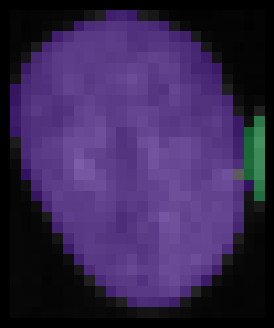

In [25]:
# select which object to plot
idx = 106 # index of the object in `nucl`

img_nucl = plate.get_image_table_idx(table_name='nuclei_ROI_table',
                                     table_idx=idx,
                                     well=my_well,
                                     pyramid_level=img_pl,
                                     as_NumPy=True)
msk_nucl = plate.get_label_table_idx(label_name='nuclei',
                                     table_name='nuclei_ROI_table',
                                     table_idx=idx,
                                     well=my_well,
                                     pyramid_level=msk_pl,
                                     as_NumPy=True)
assert img_nucl.shape[1:] == msk_nucl.shape

# plot 
plotting.plot_image(im=img_nucl, msk=msk_nucl, msk_alpha=0.3,
                    channels=[0], channel_colors=['white'], channel_ranges=[[100,600]],
                    fig_width_inch=4, fig_height_inch=4, fig_dpi=100)

## Calculations on the image data

To save memory, images are stored on disk and only loaded when needed
(for implementation details see the [`dask` Array
documentation](https://docs.dask.org/en/stable/array.html)).

This can be demonstrated by `type(img)`:

In [26]:
type(img) # note that the image is an 'on-disk' array

dask.array.core.Array

To force loading of the data into memory, you can call `.compute()`:

In [27]:
type(img.compute()) # .compute() triggers loading it into memory

numpy.ndarray

In general, you can use `dask` arrays like `numpy` arrays. For example,
we can threshold the image:

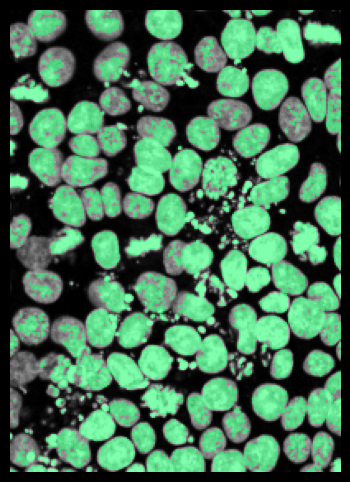

In [28]:
# threshold
img_mask = img[0,0]>300
# ... and compute to numpy array
img_mask = img_mask.compute()

# plot 
plotting.plot_image(im=img[:,0], msk=img_mask, msk_alpha=0.5,
                    fig_width_inch=6, fig_height_inch=6, fig_dpi=100)

This is of course not a recommended way to segment this image, but
rather meant to demonstrate that the `dask` arrays can be used just like
`numpy` arrays.

# Session info

In [29]:
import session_info
session_info.show()

/opt/hostedtoolcache/Python/3.11.13/x64/lib/python3.11/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)

Click to view session information 
 
-----
anndata 0.12.2
dask 2025.9.1
ez_zarr 0.4.2
matplotlib 3.8.2
numpy 1.26.4
pandas 2.3.2
requests 2.32.5
session_info 1.0.0
skimage 0.22.0
-----
 
 
 Click to view modules imported as dependencies 
 
PIL 11.3.0
anyio NA
arrow 1.3.0
asttokens NA
attr 25.3.0
attrs 25.3.0
babel 2.17.0
certifi 2025.08.03
charset_normalizer 3.4.3
cloudpickle 3.1.1
comm 0.2.3
crc32c NA
cycler 0.12.1
cython_runtime NA
dateutil 2.9.0.post0
debugpy 1.8.17
decorator 5.2.1
defusedxml 0.7.1
donfig 0.8.1.post1
executing 2.2.1
fastjsonschema NA
fqdn NA
fsspec 2025.9.0
h5py 3.14.0
idna 3.10
importlib_metadata NA
ipykernel 6.30.1
isoduration NA
jedi 0.19.2
jinja2 3.1.6
json5 0.12.1
jsonpointer 3.0.0
jsonschema 4.25.1
jsonschema_specifications NA
jupyter_events 0.12.0
jupyter_server 2.17.0
jupyterlab_server 2.27.3
kiwisolver 1.4.9
lark 1.2.2
lazy_loader 0.4
legacy_api_wrap NA
markupsafe 3.0.2
matplotlib_inline 0.1.7
mpl_toolkits NA
natsort 8.4.0
nbformat 5.10.4
numcodecs 0.16.3
overrides NA
packaging 25.0
parso 0.8.5
platformdirs 4.4.0
prometheus_client NA
prompt_toolkit 3.0.52
psutil 7.1.0
pure_eval 0.2.3
pydev_ipython NA
pydevconsole NA
pydevd 3.2.3
pydevd_file_utils NA
pydevd_plugins NA
pydevd_tracing NA
pygments 2.19.2
pyparsing 3.2.5
pythonjsonlogger NA
pytz 2025.2
referencing NA
rfc3339_validator 0.1.4
rfc3986_validator 0.1.1
rfc3987_syntax NA
rpds NA
scipy 1.16.2
send2trash NA
six 1.17.0
sniffio 1.3.1
stack_data 0.6.3
tabulate 0.9.0
testing NA
tlz 1.0.0
toolz 1.0.0
tornado 6.5.2
traitlets 5.14.3
typing_extensions NA
uri_template NA
urllib3 2.5.0
wcwidth 0.2.13
webcolors NA
websocket 1.8.0
yaml 6.0.2
zarr 3.1.3
zipp NA
zmq 27.1.0
zoneinfo NA
 
 <!-- seems like this ends pre, so might as well be explicit -->
 
-----
IPython 9.5.0
jupyter_client 8.6.3
jupyter_core 5.8.1
jupyterlab 4.4.7
notebook 7.4.5
-----
Python 3.11.13 (main, Jun 4 2025, 04:12:12) [GCC 13.3.0]
Linux-6.11.0-1018-azure-x86_64-with-glibc2.39
-----
Session information updated at 2025-09-22 12:39